In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from helpers import load_config


In [3]:
configs = load_config(os.path.join("configs", "configs.yaml"))

study_path = configs["STORAGE_DIR_STUDY2"]

In [4]:
one_hot_df = pd.read_csv(
    os.path.join(study_path, "all_samples_40_genes_one_hot.csv")
)
one_hot_df = one_hot_df.rename(
    columns={"Tumor_Sample_Barcode": "SAMPLE_ID"}
)
one_hot_df.head(2)

,SAMPLE_ID,APC,BAX,BMPR1A,BRAF,DCC,EGFR,ENG,EPCAM,ERBB2,...,PIK3CD,POLD1,POLE,PTEN,RNF43,SCG5,SMAD4,STK11,TGFBR2,TP53
0,TCGA-3L-AA1B-01,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-4N-A93T-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
one_hot_df.drop("SAMPLE_ID", axis=1).sum().sort_values(ascending=False)

APC       388
TP53      317
KRAS      220
PIK3CA    151
SMAD4      70
BRAF       63
DCC        51
RNF43      48
POLE       42
PTEN       37
NRAS       35
POLD1      33
NTRK2      30
NTRK3      30
MSH2       28
MSH6       28
ERBB2      27
EGFR       26
MLH1       23
TGFBR2     23
ENG        18
PIK3CD     18
GREM1      17
NTRK1      15
MSH3       14
PIK3CB     14
MUTYH      13
BMPR1A     11
STK11      10
BAX         8
EPCAM       5
NTHL1       5
SCG5        2
dtype: int64

In [6]:
one_hot_df = one_hot_df[["SAMPLE_ID", "APC", "TP53", "KRAS", "PIK3CA", "SMAD4", "DCC", "RNF43", "POLE", "POLD1", "NTRK2", "BRAF", "NRAS", "PTEN"]]

one_hot_df.drop("SAMPLE_ID", axis=1).sum().sort_values(ascending=False)

APC       388
TP53      317
KRAS      220
PIK3CA    151
SMAD4      70
BRAF       63
DCC        51
RNF43      48
POLE       42
PTEN       37
NRAS       35
POLD1      33
NTRK2      30
dtype: int64

In [7]:
patho_df = pd.read_csv(
    os.path.join(study_path, "all_patient_sample_merge_relevant_columns.csv")
)
patho_df.head(2)

,PATIENT_ID,AGE,SEX,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,PERSON_NEOPLASM_CANCER_STATUS,PRIOR_DX,RADIATION_THERAPY,WEIGHT,PFS_STATUS,PFS_MONTHS,GENETIC_ANCESTRY_LABEL,SAMPLE_ID,ONCOTREE_CODE,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS
0,TCGA-3L-AA1B,61.0,Female,M0,N0,T2,Tumor Free,No,No,63.3,0:CENSORED,15.616267,AFR_ADMIX,TCGA-3L-AA1B-01,COAD,19.0,0.3057,0.05,4.033333
1,TCGA-4N-A93T,67.0,Male,M0,N1B,T4A,With Tumor,No,No,134.0,0:CENSORED,4.799947,AFR,TCGA-4N-A93T-01,COAD,13.0,0.3317,0.69,2.900000


In [8]:
patho_df = patho_df[["SAMPLE_ID", "PFS_MONTHS", "PFS_STATUS"]]
patho_df.head(2)

,SAMPLE_ID,PFS_MONTHS,PFS_STATUS
0,TCGA-3L-AA1B-01,15.616267,0:CENSORED
1,TCGA-4N-A93T-01,4.799947,0:CENSORED


In [9]:
patho_df['PFS_STATUS'] = patho_df['PFS_STATUS'].replace({'0:CENSORED': False, '1:PROGRESSION': True}).astype(bool)
patho_df.head()

,SAMPLE_ID,PFS_MONTHS,PFS_STATUS
0,TCGA-3L-AA1B-01,15.616267,False
1,TCGA-4N-A93T-01,4.799947,False
2,TCGA-4T-AA8H-01,12.657396,False
3,TCGA-5M-AAT4-01,1.610941,True
4,TCGA-5M-AAT6-01,7.199921,True


In [10]:
df = pd.merge(patho_df, one_hot_df, on="SAMPLE_ID", how="inner")
df.head(2)

,SAMPLE_ID,PFS_MONTHS,PFS_STATUS,APC,TP53,KRAS,PIK3CA,SMAD4,DCC,RNF43,POLE,POLD1,NTRK2,BRAF,NRAS,PTEN
0,TCGA-3L-AA1B-01,15.616267,False,1,0,0,1,0,0,0,0,0,0,1,1,0
1,TCGA-4N-A93T-01,4.799947,False,0,1,1,0,0,0,0,0,0,0,0,0,0


In [11]:
df = df.dropna()

## Kaplan Meier Estimator

In [12]:
df.shape

(492, 16)

Text(0.5, 0, 'time $t$')

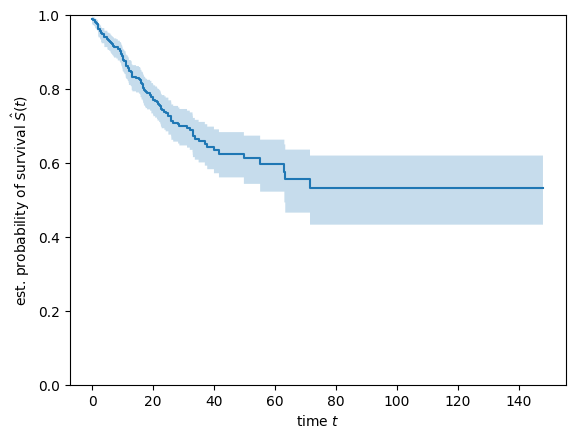

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    df["PFS_STATUS"], df["PFS_MONTHS"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [13]:
data_x_numeric = df.drop(["SAMPLE_ID", "PFS_MONTHS", "PFS_STATUS"], axis=1)
data_x_numeric.head(2)

,APC,TP53,KRAS,PIK3CA,SMAD4,DCC,RNF43,POLE,POLD1,NTRK2,BRAF,NRAS,PTEN
0,1,0,0,1,0,0,0,0,0,0,1,1,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [14]:
data_y = np.array(list(zip(df['PFS_STATUS'], df['PFS_MONTHS'])),
                            dtype=[('PFS_STATUS', 'bool'), ('PFS_MONTHS', 'float')])

print(data_y[0:5], data_y.shape)

[(False, 15.61626722) (False,  4.7999474 ) (False, 12.65739554)
 ( True,  1.61094125) ( True,  7.1999211 )] (492,)


In [15]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [16]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

APC      -0.536535
TP53     -0.046357
KRAS      0.388388
PIK3CA   -0.129961
SMAD4     0.220653
DCC       0.266001
RNF43    -0.150581
POLE      0.612451
POLD1    -0.170539
NTRK2     0.065506
BRAF     -0.618356
NRAS     -0.104287
PTEN     -0.697989
dtype: float64

In [17]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(df["PFS_STATUS"], df["PFS_MONTHS"], prediction)
result[0]


0.6222431380529623

In [18]:
import numpy as np


def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x_numeric.values, data_y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

KRAS      0.561560
APC       0.528453
BRAF      0.521610
PTEN      0.520618
POLE      0.517883
DCC       0.517044
SMAD4     0.514741
TP53      0.508484
RNF43     0.507110
NTRK2     0.504757
POLD1     0.500903
NRAS      0.498257
PIK3CA    0.493412
dtype: float64

## Redoing for pathological data

In [19]:
patho_df = pd.read_csv(
    os.path.join(study_path, "all_patient_sample_merge_relevant_columns.csv")
)
patho_df.head(2)

,PATIENT_ID,AGE,SEX,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,PERSON_NEOPLASM_CANCER_STATUS,PRIOR_DX,RADIATION_THERAPY,WEIGHT,PFS_STATUS,PFS_MONTHS,GENETIC_ANCESTRY_LABEL,SAMPLE_ID,ONCOTREE_CODE,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS
0,TCGA-3L-AA1B,61.0,Female,M0,N0,T2,Tumor Free,No,No,63.3,0:CENSORED,15.616267,AFR_ADMIX,TCGA-3L-AA1B-01,COAD,19.0,0.3057,0.05,4.033333
1,TCGA-4N-A93T,67.0,Male,M0,N1B,T4A,With Tumor,No,No,134.0,0:CENSORED,4.799947,AFR,TCGA-4N-A93T-01,COAD,13.0,0.3317,0.69,2.900000


In [20]:
patho_df.isnull().sum().sort_values(ascending=False)

WEIGHT                           277
RADIATION_THERAPY                104
PERSON_NEOPLASM_CANCER_STATUS     63
TMB_NONSYNONYMOUS                 60
MSI_SCORE_MANTIS                  37
MSI_SENSOR_SCORE                  10
PATH_M_STAGE                       9
ANEUPLOIDY_SCORE                   8
PFS_MONTHS                         4
PFS_STATUS                         3
PATH_N_STAGE                       2
PATH_T_STAGE                       2
PRIOR_DX                           2
SEX                                2
AGE                                2
GENETIC_ANCESTRY_LABEL             0
SAMPLE_ID                          0
ONCOTREE_CODE                      0
PATIENT_ID                         0
dtype: int64

In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
patho_df['WEIGHT'] = imputer.fit_transform(patho_df[['WEIGHT']])


In [22]:
patho_df["RADIATION_THERAPY"].value_counts(dropna=False)

RADIATION_THERAPY
No     463
NaN    104
Yes     27
Name: count, dtype: int64

In [23]:
patho_df = patho_df.dropna()

In [24]:
patho_df['PFS_STATUS'] = patho_df['PFS_STATUS'].replace({'0:CENSORED': False, '1:PROGRESSION': True}).astype(bool)

/var/folders/_0/qrjsyj4n0r951n63lt8qdzrc0000gn/T/ipykernel_15589/1348734535.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  patho_df['PFS_STATUS'] = patho_df['PFS_STATUS'].replace({'0:CENSORED': False, '1:PROGRESSION': True}).astype(bool)


In [25]:
data_x = patho_df.drop(["PATIENT_ID", "SAMPLE_ID", "PFS_STATUS", "PFS_MONTHS"], axis=1)
data_y = patho_df[["PFS_STATUS", "PFS_MONTHS"]]

In [26]:
data_y = np.array(list(zip(patho_df['PFS_STATUS'], patho_df['PFS_MONTHS'])),
                            dtype=[('PFS_STATUS', 'bool'), ('PFS_MONTHS', 'float')])



Text(0.5, 0, 'time $t$')

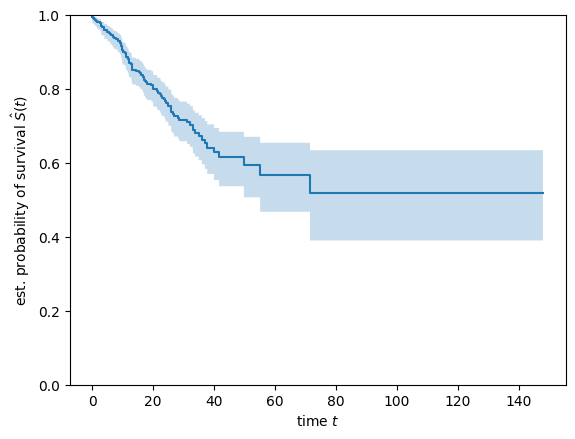

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    patho_df["PFS_STATUS"], patho_df["PFS_MONTHS"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [28]:
from colorectal_adenocarcinoma.data_preprocessor import preprocess_data

In [29]:
data_x = preprocess_data(data_x)

Label encoded PATH_M_STAGE
Label encoded PATH_N_STAGE
Label encoded PATH_T_STAGE


In [37]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)

CoxPHSurvivalAnalysis()

In [41]:
pd.Series(estimator.coef_, index=data_x.columns)

AGE                                         0.002795
PATH_M_STAGE                                0.923408
PATH_N_STAGE                                0.529020
PATH_T_STAGE                                0.582798
WEIGHT                                     -0.011880
GENETIC_ANCESTRY_LABEL                     -0.783405
ANEUPLOIDY_SCORE                           -0.004555
MSI_SCORE_MANTIS                            2.845361
MSI_SENSOR_SCORE                           -0.045237
TMB_NONSYNONYMOUS                          -0.002340
SEX_Male                                    0.082931
PERSON_NEOPLASM_CANCER_STATUS_With Tumor    1.369722
PRIOR_DX_Y                                 -0.197228
RADIATION_THERAPY_Yes                       0.730186
ONCOTREE_CODE_MACR                         -0.361220
ONCOTREE_CODE_READ                         -0.333630
dtype: float64

In [ ]:
x_new = pd.DataFrame.from_dict(
    {
        1: [61.0, 0, 0, 1, 60, 1, 0, 1],
        2: [65, 0, 0, 1, 60, 1, 0, 0],
        3: [65, 0, 1, 0, 60, 1, 0, 0],
        4: [65, 0, 1, 0, 60, 1, 0, 1],
    },
    columns=data_x_numeric.columns,
    orient="index",
)
x_new

In [54]:
data_y[4]

(True, 7.1999211)

In [46]:
target_value = (False, 74.56356643)
index = np.where((data_y['PFS_STATUS'] == target_value[0]) & (data_y['PFS_MONTHS'] == target_value[1]))[0]

In [65]:
x_new = data_x.iloc[[269, 4]]

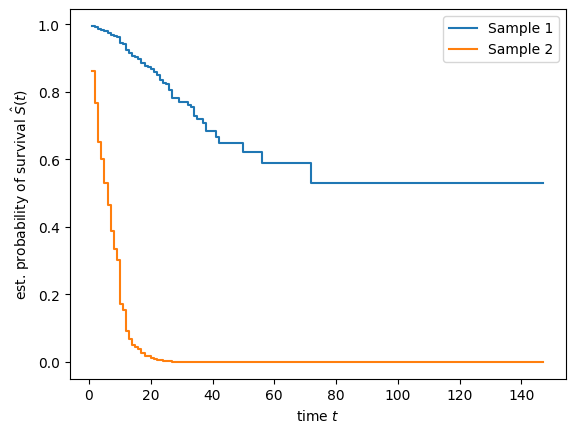

In [66]:
import numpy as np

pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 148)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [67]:
x_new

,AGE,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,WEIGHT,GENETIC_ANCESTRY_LABEL,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS,SEX_Male,PERSON_NEOPLASM_CANCER_STATUS_With Tumor,PRIOR_DX_Y,RADIATION_THERAPY_Yes,ONCOTREE_CODE_MACR,ONCOTREE_CODE_READ
399,69.0,0.0,2.0,3.0,88.0,1,17.0,0.3963,0.88,5.333333,1,0,0,0,0,0
4,40.0,1.0,2.5,4.0,99.1,0,3.0,0.6600,20.58,62.166667,0,1,0,0,0,0
